In [1]:
push!(LOAD_PATH, pwd())
using LightGraphs, IndirectRec, GraphConnectivityTheory,GraphCreation
using PyCall, PyPlot, Distributions
using Dierckx
@pyimport seaborn as sns

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


## READ DATA

In [2]:
data_dir_path = "../data/per_node_data/"
filenames = split(readall(pipeline(`ls $data_dir_path`,`grep misc`)));
filenames[:]

4-element Array{SubString{ASCIIString},1}:
 "misc_graphs_2016-04-09T02:26:44.jld"
 "misc_graphs_2016-04-09T20:20:44.jld"
 "misc_graphs_2016-04-28T12:07:05.jld"
 "misc_graphs_2016-04-29T09:25:12.jld"

In [3]:
using JLD
d = JLD.load(data_dir_path * filenames[end])
hist_all_clustering = d["hist_all_clustering"]
hist_all_degrees = d["hist_all_degrees"]
hist_all_thresholds = d["hist_all_thresholds"]
N_range = d["N_range"]
C_range = d["C_range"]
k_range = d["k_range"]
n_range = d["n_range"]
graph_name_range = d["graph_name_range"]
graph_type_range = d["graph_type_range"]
p = d["p"]
println(p)

0.05


In [5]:
p

0.05

## Preprocess

In [42]:
mean_degrees = zeros(size(hist_all_degrees)) 
mean_thresholds = zeros(size(hist_all_degrees)) 
mean_clustering = zeros(size(hist_all_degrees)) 
hist_all_clustering_means = copy(hist_all_clustering)
for i = 1:length(n_range)
    for j = 1:length(graph_type_range)
        for (iN,N) in enumerate(N_range)
            for (iC,C) in enumerate(C_range)
                for (ik,k) in enumerate(k_range)
                    mean_degrees[i,j,iN,iC,ik] =  mean(hist_all_degrees[i,j,iN,iC,ik])
                    mean_thresholds[i,j,iN,iC,ik] =  mean(hist_all_thresholds[i,j,iN,iC,ik])
                    mean_clustering[i,j,iN,iC,ik] =  mean(hist_all_clustering[i,j,iN,iC,ik])
                    hist_all_clustering_means[i,j,iN,iC,ik] = fill(mean(hist_all_clustering[i,j,iN,iC,ik]),size(hist_all_clustering[i,j,iN,iC,ik]))
                end
            end
        end
    end
end


In [8]:
function concat_arrays(arr_of_arrs)
    arr = []
    for curr in arr_of_arrs
        arr = vcat(arr,curr)
    end
    arr
end

function cut_array_to_domain(to_cut::Array{Float64,1},domain_arr::Array{Float64,1})
    return to_cut[minimum(domain_arr) .< to_cut .< maximum(domain_arr) ]
end

function cut_array_to_domain(to_cut::Array{Array{Float64,1},1},domain_arr::Array{Array{Float64,1},1})
    mask = minimum(domain_arr[1]) .< to_cut[1] .< maximum(domain_arr[1])
    for i in 2:length(to_cut)
        mask = mask & ( minimum(domain_arr[1]) .< to_cut[1] .< maximum(domain_arr[1]))
    end
    out = []
    for i in 1:length(to_cut)
        push!(out,to_cut[i][mask])
    end
    return out,mask
end


function compute_rms_difference(spl::Spline2D,xx::Array{Float64,1},yy::Array{Float64,1},zz::Array{Float64,1})
    zz_prime = evaluate(spl,xx,yy)
    return sqrt(mean((zz-zz_prime).^2))#./zz
end

function compute_rms_difference1D(spl::Spline1D,xx::Array{Float64,1},yy::Array{Float64,1})
    yy_prime = evaluate(spl,xx)
    return sqrt(mean((yy-yy_prime).^2))#./zz
end

function compute_difference_directional(spl::Spline2D,xx::Array{Float64,1},yy::Array{Float64,1},zz::Array{Float64,1})
    zz_prime = evaluate(spl,xx,yy)
    return mean((zz-zz_prime))#./(abs(zz) + 0.01))
end

function get_p_known_from_clustering_degree(p,k,c)
    return 1 - (1-p).*(1-p.^2).^((k-1).*c)
end

function get_p_known_from_n(p,n)
    return 1 - (1-p).*(1-p.^2).^(n)
end

get_p_known_from_n (generic function with 1 method)

In [49]:
xlimit = 1000
differences = zeros(length(n_range))
differences1D = zeros(length(n_range))
differences_mean = zeros(length(n_range)) 
std_global = std(convert(Array{Float64,1},concat_arrays(hist_all_thresholds[:])))
(iN,N) = (3,1000)
for (i,n) in enumerate(n_range)
    
    mask = 0 .< convert(Array{Float64,1},concat_arrays(hist_all_degrees[i,:,:,:,:])) .< xlimit
    xx = convert(Array{Float64,1},concat_arrays(hist_all_degrees[i,:,:,:,:])[mask])
    yy = convert(Array{Float64,1},concat_arrays(hist_all_clustering[i,:,:,:,:])[mask])
    yy_means = convert(Array{Float64,1},concat_arrays(hist_all_clustering_means[i,:,:,:,:])[mask])
    zz = convert(Array{Float64,1},concat_arrays(hist_all_thresholds[i,:,:,:,:])[mask])
    
    s = length(xx)/10
    
    nn = (xx-1).*yy
    sort_vec = sortperm(nn)
    zz_sorted = zz[sort_vec]
    nn_sorted = nn[sort_vec]
    spl1 = Spline1D(nn_sorted,zz_sorted,s=s,bc="extrapolate")
    spl = Spline2D(nn,yy_means,zz,s=s)#Spline2D(xx,yy,zz,s=s)
    differences[i] = compute_rms_difference(spl,nn,yy_means,zz) #(spl,xx,yy,zz)
    differences1D[i] = compute_rms_difference1D(spl1,nn,zz)
    differences_mean[i] = sqrt(mean((zz-mean(zz)).^2))
    println("n: $n")
    if i == 1
        println("one variable: ", sqrt(mean((zz- get_p_known_from_clustering_degree(p,xx,yy)).^2)))
    end
    println("2D: $(differences[i])")#/differences_mean[i])
    println("mean: ",  differences_mean[i])
    println("1D: ", differences1D[i])
end
#println(sum(mask)/length(mask))
# println(differences)

n: 2
one variable: 0.006382765424119507
2D: 0.006380911129375973
mean: 0.026849584184683452
1D: 0.00638220985944524
n: 3
2D: 0.013096860785287406
mean: 0.08050410033765537
1D: 0.01630716196872302
n: 4
2D: 0.03355105980163849
mean: 0.14045384937777008
1D: 0.045598167525582656
n: 5
2D: 0.05466222075625118
mean: 0.18457979807085612
1D: 0.07757841863306493
n: 7
2D: 0.09602940221752411
mean: 0.2526311413558318
1D: 0.15517949824751823
n: 100
2D: 0.10665319416705563
mean: 0.3137922033347178
1D: 0.23672682799658537
n: 1000
2D: 0.10837906961523587
mean: 0.31294943374417894
1D: 0.23683723603093954



Use "Dict{Any,Any}(a=>b, ...)" instead.

Use "Dict{Any,Any}(a=>b, ...)" instead.


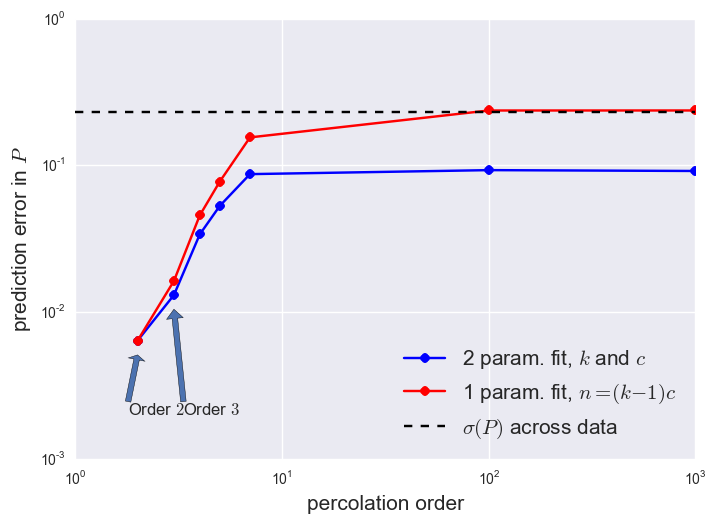

In [11]:
pygui(false)
loglog(n_range,differences,"-ob",label=L"2 param. fit, $k$ and $c$")
loglog(n_range,differences1D,"-or",label=L"1 param. fit, $n = (k-1)c$")
#loglog(n_range,differences_mean,"--ok",label=L"\sigma")
axhline(std_global,color="k",linestyle="--",label=latexstring("\$ \\sigma(P)\$ across data"))
#axhline(std_global,linestyle="--k")
xlabel("percolation order",size=15)
ylabel(L"prediction error in $P$",size=15)
legend(loc="lower right",prop={"size" => 15})
ylims = [1e-3,1] 
for i = 1:2
    xpos = n_range[i]
    ypos = differences[i]
    delta = 2e-3
    annotate(s=latexstring("Order \$ $(n_range[i])\$"),xy=(xpos,0.8*ypos),xytext =(0.9^(3-2*i)*xpos,2*ylims[1]), arrowprops={"linestyle"=>"solid"})
end
#
#savefig("../figures/prediction_err_vs_percolation_order.png")


Use "Dict{Any,Any}(a=>b, ...)" instead.
/Users/julian/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


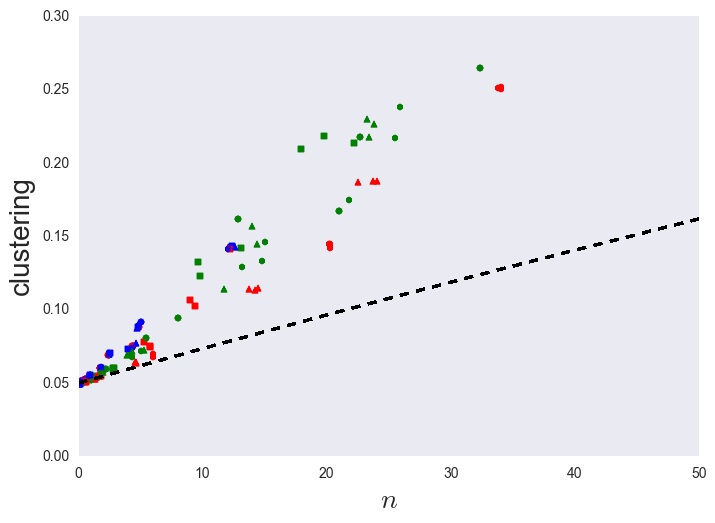

In [12]:
colormap_arr = ["b","r","g","y","c","k"]
markers_arr = ["o","s","^","h","X","D"]
linestyle_arr = ["-p","-^","-s","-o","-D"]
pygui(false)
close("all")
figure(1)
(i,n) = (2,3)
#(j,graph_type) = (3,:gamma_fb)
#(ik,k) = (3,30) 
xlimit=50
for (j,graph_type) in enumerate(graph_type_range)
for (iN,N) in enumerate(N_range)
for (iC,C) in enumerate(C_range)
for (ik,k) in enumerate(k_range)
for (j,graph_type) in enumerate(graph_type_range)
    scatter((mean_degrees[i,j,iN,iC,ik]-1).*mean_clustering[i,j,iN,iC,ik],
                mean_thresholds[i,j,iN,iC,ik],marker=markers_arr[iC],color=colormap_arr[j],alpha=0.8)
        xx = collect(0:0.1:xlimit)
    plot(xx,1 - (1-p).*(1-p^2).^(xx),"--k")
end
end
end
end
end
xlim([0,xlimit])
ylabel("clustering",size=20)
xlabel(L"$n$",size=20)
# zlabel(L"$P$",size=20)
grid()
legend(prop={"size"=>10},loc="center right")

In [83]:

colormap_arr = ["b","r","g","y","c","k"]
linestyle_arr = ["-p","-^","-s","-o","-D"]
markers_arr = ["o","s","^","x","h","D"]
pygui(true)
close("all")
#figure(1)
xlimit=50
(i,n) = (6,100)
# for (i,n) in enumerate(n_range)
mask = 0 .< squeeze(mean_degrees[i,:],1) .< xlimit
xx = squeeze(mean_degrees[i,:],1)[mask]
yy = squeeze(mean_clustering[i,:],1)[mask]
zz = squeeze(mean_thresholds[i,:],1)[mask]
s = length(xx)/10
spl = Spline2D(xx,yy,zz,s=s)
xxx = collect(minimum(xx):1:xlimit)
yyy = collect(minimum(yy):0.01:maximum(yy))
ylimit = maximum(zz)

nn = (xx-1).*yy
sort_vec = sortperm(nn)
zz_sorted = zz[sort_vec]
nn_sorted = nn[sort_vec]
spl1 = Spline1D(nn_sorted,zz_sorted,s=s,bc="extrapolate")
gg = sns.jointplot(nn,zz,kind="kde")
xx = collect(0:0.1:maximum(nn))
#plot(xx,1 - (1-p).*(1-p^2).^(xx))
if n == 2
gg[:ax_joint][:plot](xx,1-(1-p).*(1-p^(2)).^(xx),"k", label="theory")
else
gg[:ax_joint][:plot](xx,evaluate(spl1,xx),"k",label="best fit")
end
#plot(xx,log10((1-p).*(1-p^(2)).^(n*xx)))

#     surf(xxx,yyy,evalgrid(spl,xxx,yyy)',alpha=0.2,color="r",rstride=10,cstride=10)
    for (j,graph_type) in enumerate(graph_type_range)
    for (iN,N) in enumerate(N_range)
    for (iC,C) in enumerate(C_range)
    for (ik,k) in enumerate(k_range)
            label = ""
            if iN ==1 && iC == 1 && ik == 1#j == 1 || l == 1
                label = "$(graph_name_range[j])"
                    gg[:ax_joint][:scatter]([-1],[0],color=colormap_arr[j],marker=markers_arr[iN],alpha=0.8,label=label)
            end
                ds = convert(Array{Float64,1},[mean_degrees[i,j,iN,iC,ik]])
                cs = convert(Array{Float64,1},[mean_clustering[i,j,iN,iC,ik]])
                ps = convert(Array{Float64,1},[mean_thresholds[i,j,iN,iC,ik]])
            gg[:ax_joint][:scatter]((ds-1).*cs,ps,color=colormap_arr[j],marker=markers_arr[iN],alpha=0.8)
#                 scatter3D(ds,cs,ps-evaluate(spl,ds,cs),color=colors_arr[j],marker=markers_arr[iC],alpha=0.05)#,linestyle_arr[1 + (l % length(linestyle_arr))],color=colors_arr[j],label=label)
     end
     end
     end
    end
# end
gg[:ax_joint][:patch][:set_visible](false)
gg[:ax_joint][:set_xlim]([0,30])
gg[:ax_joint][:set_ylim]([0,min(1,ylimit*1.5)])
gg[:ax_joint][:set_ylabel]("P",size=20)
gg[:ax_joint][:set_xlabel](L"$n = (k-1)c$",size=20)
# zlabel(L"$P$",size=20)
#grid()
gg[:ax_joint][:legend](prop={"size"=>10},loc="lower right")
savefig("../figures/P_vs_misc_graphs_means_scatter_order_$n.png",bbox_inches="tight")

2016-04-12 03:46:38.674 julia[85998:2301708] setCanCycle: is deprecated.  Please use setCollectionBehavior instead
2016-04-12 03:46:38.695 julia[85998:2301708] setCanCycle: is deprecated.  Please use setCollectionBehavior instead

Use "Dict{Any,Any}(a=>b, ...)" instead.


In [67]:
colormap_arr = ["b","r","g","y","c","k"]
linestyle_arr = ["-p","-^","-s","-o","-D"]
markers_arr = ["o","s","^","x","h","D"]
pygui(true)
close("all")
#figure(1)
xlimit=50
(i,n) = (1,2)
# for (i,n) in enumerate(n_range)
mask = 0 .< convert(Array{Float64,1},concat_arrays(hist_all_degrees[i,:])) .< xlimit
xx = convert(Array{Float64,1},concat_arrays(hist_all_degrees[i,:])[mask])
yy = convert(Array{Float64,1},concat_arrays(hist_all_clustering[i,:])[mask])
zz = convert(Array{Float64,1},concat_arrays(hist_all_thresholds[i,:])[mask])
s = length(xx)/10
spl = Spline2D(xx,yy,zz,s=s)
xxx = collect(minimum(xx):1:xlimit)
yyy = collect(minimum(yy):0.01:maximum(yy))
ylimit = maximum(zz)

nn = (xx-1).*yy
sort_vec = sortperm(nn)
zz_sorted = zz[sort_vec]
nn_sorted = nn[sort_vec]
spl1 = Spline1D(nn_sorted,zz_sorted,s=s,bc="extrapolate")
gg = sns.jointplot(nn,zz,kind="kde")
xx = collect(0:0.1:xlimit)
#plot(xx,1 - (1-p).*(1-p^2).^(xx))
if n == 2
    gg[:ax_joint][:plot](xx,1-(1-p).*(1-p^(2)).^(xx),"k", label="theory")
else
gg[:ax_joint][:plot](xx,evaluate(spl1,xx),"k",label="best fit")
end

#     surf(xxx,yyy,evalgrid(spl,xxx,yyy)',alpha=0.2,color="r",rstride=10,cstride=10)
    for (j,graph_type) in enumerate(graph_type_range)
    for (iN,N) in enumerate(N_range)
    for (iC,C) in enumerate(C_range)
    for (ik,k) in enumerate(k_range)
            label = ""
            if iN ==1 && iC == 1 && ik == 1#j == 1 || l == 1
                label = "$(graph_name_range[j])"
                    gg[:ax_joint][:scatter]([-1],[0],color=colormap_arr[j],marker=markers_arr[iN],alpha=0.8,label=label)
            end
            ds = convert(Array{Float64,1},hist_all_degrees[i,j,iN,iC,ik])
            cs = convert(Array{Float64,1},hist_all_clustering[i,j,iN,iC,ik])
            ps = convert(Array{Float64,1},hist_all_thresholds[i,j,iN,iC,ik])
            gg[:ax_joint][:scatter]((ds-1).*cs,ps,color=colormap_arr[j],marker=markers_arr[iN],alpha=0.1)
#                 scatter3D(ds,cs,ps-evaluate(spl,ds,cs),color=colors_arr[j],marker=markers_arr[iC],alpha=0.05)#,linestyle_arr[1 + (l % length(linestyle_arr))],color=colors_arr[j],label=label)
     end
     end
     end
    end
# end
gg[:ax_joint][:patch][:set_visible](false)
gg[:ax_joint][:set_xlim]([0,50])
gg[:ax_joint][:set_ylim]([0,min(1,ylimit*1.5)])
gg[:ax_joint][:set_ylabel]("P",size=20)
gg[:ax_joint][:set_xlabel](L"$n = (k-1)c$",size=20)
# zlabel(L"$P$",size=20)
#grid()
gg[:ax_joint][:legend](prop={"size"=>10},loc="lower right")
savefig("../figures/P_vs_misc_graphs_scatter_order_$n.png",bbox_inches="tight")

2016-04-12 03:37:20.563 julia[85998:2301708] setCanCycle: is deprecated.  Please use setCollectionBehavior instead
2016-04-12 03:37:20.598 julia[85998:2301708] setCanCycle: is deprecated.  Please use setCollectionBehavior instead

Use "Dict{Any,Any}(a=>b, ...)" instead.


In [19]:
close("all")

In [141]:
azim = 90
elev = 0
figure(1)
ax = gca()
ax[:view_init](azim=azim, elev = elev)

In [9]:
close("all")

In [40]:
colormap_arr = ["b","r","g","c","y","k"]
linestyle_arr = ["-p","-^","-s","-o","-D"]
markers_arr = ["o","s","^","h","x","D"]
pygui(true)
close("all")
#figure(1)
xlimit=50
(i,n) = (6,100)
# for (i,n) in enumerate(n_range)
mask = 0 .< convert(Array{Float64,1},concat_arrays(hist_all_degrees[i,:])) .< xlimit
xx = convert(Array{Float64,1},concat_arrays(hist_all_degrees[i,:])[mask])
yy = convert(Array{Float64,1},concat_arrays(hist_all_clustering[i,:])[mask])
zz = convert(Array{Float64,1},concat_arrays(hist_all_thresholds[i,:])[mask])
s = length(xx)/10
spl = Spline2D(xx,yy,zz,s=s)
xxx = collect(minimum(xx):1:xlimit)
yyy = collect(minimum(yy):0.01:maximum(yy))
ylimit = maximum(zz)

nn = (xx-1).*yy
sort_vec = sortperm(nn)
zz_sorted = zz[sort_vec]
nn_sorted = nn[sort_vec]
spl1 = Spline1D(nn_sorted,zz_sorted,s=s,k=2,bc="extrapolate")
xx = collect(0:0.1:xlimit)
#plot(xx,1 - (1-p).*(1-p^2).^(xx))
if n == 2
    plot(xx,1-(1-p).*(1-p^(2)).^(xx),"k", label="theory")
else
    plot(xx,evaluate(spl1,xx),"k",label="best fit")
end

#     surf(xxx,yyy,evalgrid(spl,xxx,yyy)',alpha=0.2,color="r",rstride=10,cstride=10)

C_target = 0.65 #0.1 0.3
C_tol = 0.05#6
#     j,graph_type = (3,:fb)
for (iC,C) in enumerate(C_range)
for (j,graph_type) in enumerate([1,2,3])#enumerate(graph_type_range[1:end])
        iN,N = (3,1000)
#     ik,k = (3,30)
#      iC,C = (4,1)
#     for (iN,N) in enumerate(N_range)
    for (ik,k) in enumerate(k_range)
            label = ""
            if iN ==1 && iC == 1 && ik == 1#j == 1 || l == 1
                label = "$(graph_name_range[j])"
                    scatter([-1],[0],color=colormap_arr[j],marker=markers_arr[iC],alpha=0.8,label=label)
            end
            ds = convert(Array{Float64,1},hist_all_degrees[i,j,iN,iC,ik])
            cs = convert(Array{Float64,1},hist_all_clustering[i,j,iN,iC,ik])
            ps = convert(Array{Float64,1},hist_all_thresholds[i,j,iN,iC,ik])
            if j > 1 && abs(mean_clustering[i,j,iN,iC,ik] - C_target) < C_tol
                scatter((ds-1).*cs,ps,color=colormap_arr[iC],marker=markers_arr[iC],alpha=0.1)
                println("graph: $(graph_name_range[j]), ideal: $C, clustering: $(mean_clustering[i,j,iN,iC,ik])")
        end
#                 scatter3D(ds,cs,ps-evaluate(spl,ds,cs),color=colors_arr[j],marker=markers_arr[iC],alpha=0.05)#,linestyle_arr[1 + (l % length(linestyle_arr))],color=colors_arr[j],label=label)
      end
      end
       end
#     end
# end
xlim([0,50])
ylim([0,min(1,ylimit*1.5)])
ylabel("P",size=20)
xlabel(L"$n = (k-1)c$",size=20)
# zlabel(L"$P$",size=20)
#grid()
legend(prop={"size"=>10},loc="lower right")
#savefig("../figures/P_vs_misc_graphs_scatter_order_$n.png",bbox_inches="tight")

graph: watts_strogatz, ideal: 0.7, clustering: 0.6666666666666636


2016-05-02 20:38:58.362 julia[33962:184231] setCanCycle: is deprecated.  Please use setCollectionBehavior instead
2016-05-02 20:38:58.387 julia[33962:184231] setCanCycle: is deprecated.  Please use setCollectionBehavior instead


graph: watts_strogatz, ideal: 0.7, clustering: 0.6989893264086671
graph: watts_strogatz, ideal: 0.7, clustering: 0.6955683213727561
graph: gamma_fb, ideal: 0.7, clustering: 0.6203108376484101



Use "Dict{Any,Any}(a=>b, ...)" instead.


PyObject <matplotlib.legend.Legend object at 0x327f50590>

In [22]:
collect(zip(graph_name_range,colormap_arr)),k_range,C_range

([("erdos_renyi","b"),("watts_strogatz","r"),("gamma_fb","g")],[5,10,30],[0.01,0.2,0.5,0.7])

In [43]:
hist_all_clustering_means

7x3x3x4x4 Array{Array{Any,1},5}:
[:, :, 1, 1, 1] =
 Any[0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045  …  0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045,0.02119733044733045]                      …  Any[0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972  …  0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972,0.10413070761367972]
 Any[0.019744949494949492,0.019744949494949492,0.019744949494949492,0.019744949494949492,0.019744949494949

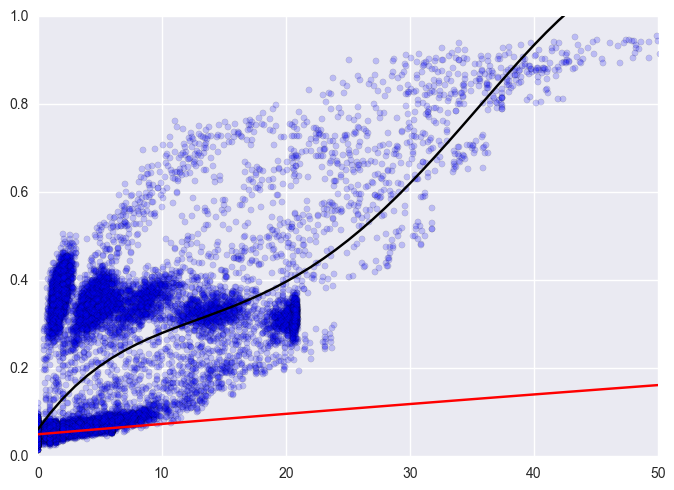

(0,1)

In [265]:




k_poly = 5
fit = curve_fit(powerlaw_model,nn,zz,ones(k_poly))
scatter(nn,zz,alpha=0.2)
xx = 0:1:50
plot(xx,powerlaw_model(xx,fit.param),"k")
plot(xx,get_p_known_from_n(p,xx),"r")

standard_error = std(powerlaw_model(nn,fit.param)-zz)
standard_error_n = std(get_p_known_from_n(p,nn)-zz)
standard_error,std(zz),standard_error_n

xlim(0,50)
ylim(0,1)

In [251]:
p

0.05

In [208]:
#std(zz-(1 - (1-p).*(1-p^2).^(nn)))
std(zz-lin_func(nn))

0.044000197626723116

In [207]:
plot(nn,lin_func(nn))

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x327e7b790>

In [206]:
lin_func(x) = p + x/50

lin_func (generic function with 1 method)

In [219]:
Pkg.add("LsqFit")

INFO: Cloning cache of DualNumbers from git://github.com/JuliaDiff/DualNumbers.jl.git
INFO: Cloning cache of LsqFit from git://github.com/JuliaOpt/LsqFit.jl.git
INFO: Cloning cache of Optim from git://github.com/JuliaOpt/Optim.jl.git
INFO: Installing DualNumbers v0.2.2
INFO: Installing LsqFit v0.0.2
INFO: Installing Optim v0.4.4
INFO: Package database updated


In [220]:
using LsqFit

INFO: METADATA is out-of-date — you may not have the latest version of LsqFit
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Precompiling module Optim...


In [231]:
function powerlaw_model(x,p) 
    y = 0
    for i = 1:length(p)
        y += p[i]*x.^(i-1)
    end
    y
end
        

powerlaw_model (generic function with 1 method)

In [229]:
xdata = collect(0:0.1:1) 
ydata = model(xdata, [1.0 2.0 3.0]) + 0.01*randn(length(xdata))

fit = curve_fit(model, xdata, ydata, [0.5, 0.5, 0.5])
# fit is a composite type (LsqFitResult), with some interesting values:
#   fit.dof: degrees of freedom
#   fit.param: best fit parameters
#   fit.resid: residuals = vector of residuals
#   fit.jacobian: estimated Jacobian at solution

# We can estimate errors on the fit parameters,
# to get 95% confidence error bars:
errors = estimate_errors(fit, 0.95)

3-element Array{Float64,1}:
 0.0154261
 0.0717713
 0.069126 

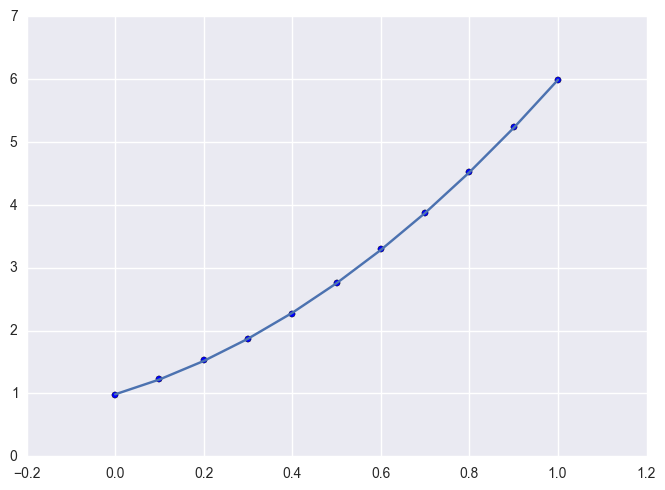

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32846ab90>

In [230]:
scatter(xdata,ydata)
plot(xdata,model(xdata,fit.param))

## Insight: given N and C of a graph, we again get a nearly collapse onto the n vs P curve!

## $C$, the global clustering, is the main distinguishing factor (it determines whether the graph is "open" or "closed") 
    - how to determine open or closed? 
        - how quickly does the number of paths increase with the length of paths?

## The smaller $N$ is, the smaller the differences between the different C's

## The smaller the order of percolation, the smaller the differences between the different C's